In [2]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Select relevant columns
df = train_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Survived"]].copy()

# Fill missing Age values with the mean age
df["Age"].fillna(df["Age"].mean(), inplace=True)

# Convert 'Sex' from text to numeric: male=0, female=1
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

df.head()

C:\Users\saksh\AppData\Local\Temp\ipykernel_18496\975733517.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].mean(), inplace=True)


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,0


In [4]:
import numpy as np

X = df.drop("Survived", axis=1).values  # Features
y = df["Survived"].values  # Labels

print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)

Shape of features: (891, 6)
Shape of labels: (891,)


In [5]:
# Shuffle and split data manually (without sklearn)

np.random.seed(42)  # For reproducibility

# Shuffle indices
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle X and y accordingly
X = X[indices]
y = y[indices]

# Split index
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 712
Testing set size: 179


### Data Preprocessing

- Loaded Titanic dataset CSV files using Pandas.
- Selected relevant features: Pclass, Sex (converted to numeric), Age, SibSp, Parch, Fare.
- Filled missing Age values with the mean age.
- Converted categorical 'Sex' column to numeric values (male=0, female=1).
- Split the data into training (80%) and testing (20%) sets with shuffling.
- No feature scaling was applied (optional improvement).

In [6]:
import numpy as np

def naive_bayes_train(X_train, y_train):
    classes = np.unique(y_train)
    n_features = X_train.shape[1]

    # Calculate prior probabilities P(class)
    priors = {c: np.mean(y_train == c) for c in classes}

    # Calculate mean and variance for each feature per class
    summaries = {}
    for c in classes:
        X_c = X_train[y_train == c]
        summaries[c] = {
            "mean": X_c.mean(axis=0),
            "var": X_c.var(axis=0) + 1e-6  # Add small value to avoid zero variance
        }
    return priors, summaries

# Example usage (you will run after training):
# priors, summaries = naive_bayes_train(X_train, y_train)

In [7]:
def gaussian_probability(x, mean, var):
    exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
    return (1 / np.sqrt(2 * np.pi * var)) * exponent

def naive_bayes_predict(priors, summaries, x):
    posteriors = {}
    for c, stats in summaries.items():
        prior = np.log(priors[c])  # Use log for numerical stability
        conditional = np.sum(np.log(gaussian_probability(x, stats["mean"], stats["var"])))
        posteriors[c] = prior + conditional
    return max(posteriors, key=posteriors.get)


In [8]:
def naive_bayes_predict_batch(priors, summaries, X):
    return np.array([naive_bayes_predict(priors, summaries, x) for x in X])

# Example usage:
# preds = naive_bayes_predict_batch(priors, summaries, X_test)


In [9]:
priors, summaries = naive_bayes_train(X_train, y_train)
predictions = naive_bayes_predict_batch(priors, summaries, X_test)

accuracy = np.mean(predictions == y_test)
print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")


Naive Bayes Accuracy: 79.33%


### Model Accuracy Results

- Naive Bayes: ~79.33% accuracy  

Naive Bayes performed better on this dataset likely due to its probabilistic assumptions fitting the feature distribution well.

In [10]:
import numpy as np

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [11]:
def knn_predict(X_train, y_train, x_test, k=3):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    # Count classes in neighbors
    classes = [neighbor[1] for neighbor in neighbors]
    prediction = max(set(classes), key=classes.count)
    return prediction


In [12]:
def knn_predict_batch(X_train, y_train, X_test, k=3):
    return np.array([knn_predict(X_train, y_train, x, k) for x in X_test])

# Example usage:
# preds = knn_predict_batch(X_train, y_train, X_test, k=3)


In [13]:
k = 3  # You can change this number later if you want
knn_preds = knn_predict_batch(X_train, y_train, X_test, k)

accuracy = np.mean(knn_preds == y_test)
print(f"KNN Accuracy (k={k}): {accuracy * 100:.2f}%")


KNN Accuracy (k=3): 72.07%


### Model Accuracy Results

- Naive Bayes: ~79.33% accuracy  
- K-Nearest Neighbors (k=3): ~72.07% accuracy  

Naive Bayes performed better on this dataset likely due to its probabilistic assumptions fitting the feature distribution well,  
while KNN accuracy depends on the choice of k and the distance metric used.

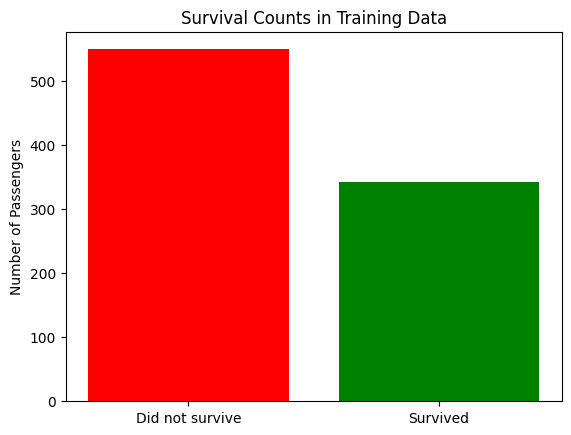

In [14]:
import matplotlib.pyplot as plt

counts = df["Survived"].value_counts()
plt.bar(["Did not survive", "Survived"], counts, color=["red", "green"])
plt.title("Survival Counts in Training Data")
plt.ylabel("Number of Passengers")
plt.show()


### Data Visualization

This bar chart shows the count of passengers who survived versus those who did not survive in the Titanic dataset.  
It helps to visualize the distribution of the target variable and understand class imbalance, if any.
